In [1]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2019-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import nxsdk.api.n2a as nx
from nxsdk.utils.plotutils import plotRaster

# vMinExp and vMaxExp Setup
This tutorial demonstrates the usage of vMaxExp and vMinExp in compartments. vMaxExp determines the maximum voltage vMax that a compartment saturates at, and vMinExp determines the minimum saturated voltage vMin with vMax=$2^{MaxExp}$−1 and vMin=$2^{vMinExp}$+1.
vMaxExp and vMinExp can be used to limit how strongly a compartment can be excited/inhibited to stop a neuron from positively/negatively accumulating. In a non-spiking multi compartment-neuron, the maximum/minmum value can be passed on to the parent or soma compartment to reset the voltage.
## Create two compartments
We illustrate vMaxExp and vMinExp settings in two compartments. Since each core can set only one vMaxExp value and one vMinExp value in the dendriteSharedCfg file, we set the two compartments in different cores. The threshold is set to a very large number to prevent compartments spiking before their voltage saturate.

vMaxExp has limited precision, and can only take one of those values: 9,11,13,15,17,19,21,23. The default value of vMaxExp is 23. vMinExp has better precision than vMaxExp, and its value can be set at any integer between 0 and 23. The default value of vMinExp is also 23.

In [3]:
net = nx.NxNet()

cxp0 = nx.CompartmentPrototype(vThMant=10000,
                               vMaxExp=17,
                               logicalCoreId=0)

cxp1 = nx.CompartmentPrototype(vThMant=10000,
                               vMinExp=16,
                               logicalCoreId=1)

cxGrp = net.createCompartmentGroup(size=2, prototype=[cxp0, cxp1], prototypeMap=[0, 1])

## Create spike generator 
A spike generator is used to stimulate the two compartments: one gets excitatory connection and the other gets inhibitory connection.

In [4]:
# create a spike generator spikeGen that sends spike at each time step
numPorts = 1
spikeGen = net.createSpikeGenProcess(numPorts)
spikeTimes = list(range(20))
spikeGen.addSpikes([0], [spikeTimes])

# connect spikeGen with compartment group cxGrp
connProto = nx.ConnectionPrototype()
spikeGen.connect(cxGrp, weight=np.array([200, -150]), prototype=connProto)

# set up probes
(vProbes, sProbes) = cxGrp.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE, nx.ProbeParameter.SPIKE])

## Run network
As printed below, the excitatory compartment voltage saturates at 131071(=$2^{17}$−1), and the inhibitory compartment voltage saturates at -65535(=$2^{16}$+1). 

In [5]:
net.run(20)
net.disconnect()

print('vMax of cxGrp[0] is: ', vProbes[0].data[19])
print('vMin of cxGrp[1] is: ', vProbes[1].data[19])

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.81:33019
INFO:DRV:      Host server up..............Done 0.19s
INFO:DRV:      Encoding axons/synapses.....Done 1.23ms
INFO:DRV:      Compiling Embedded snips....Done 0.17s
INFO:DRV:      Encoding probes.............Done 0.12ms
INFO:DRV:      Booting up..................Done 2.70s
INFO:DRV:      Configuring registers.......Done 3.74ms
INFO:DRV:      Transferring spikes.........Done 1.49ms
INFO:DRV:      Transferring probes.........Done 2.42ms
INFO:DRV:      Executing...................Done 3.10ms
INFO:DRV:      Processing timeseries.......Done 6.08ms
INFO:DRV:  Executor: 20 timesteps..........Done 3.10s
vMax of cxGrp[0] is:  131071
vMin of cxGrp[1] is:  -65535


## Show results

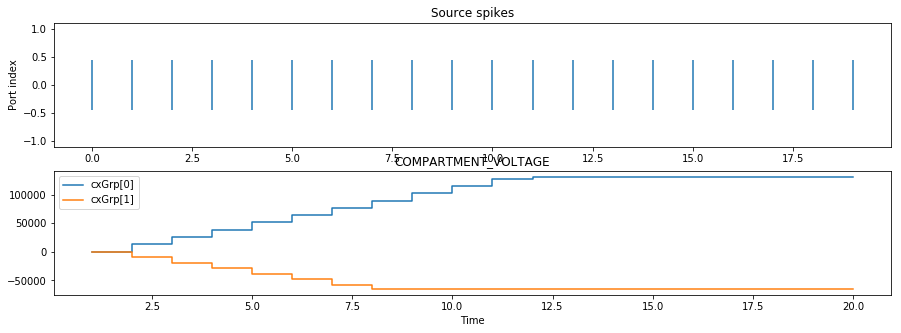

In [6]:
# fig = plt.figure(1, figsize=(18,10))
fig = plt.figure(1, figsize=(15,5))
# Plot source spikes
plt.subplot(2,1,1)
plotRaster([spikeTimes])
plt.ylabel('Port index')
plt.title('Source spikes')
# Plot compartmentVoltages
ax2 = plt.subplot(2,1,2)
vh = vProbes.plot()
ax2.legend(vh, ['cxGrp[0]', 'cxGrp[1]'])

plt.show()

.. code-links:: python clear